### First step

In [55]:
# import all packages
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt

# deep learning module
import tensorflow as tf 
from tensorflow import keras

# regular supervised learning
from sklearn.model_selection import train_test_split

**Data Description**<br>
Attached are the absolute value (unitless) and phase value (in unit of rad) of the sound field distribution corresponding to 20 different input locations.

In each file, there is a matrix containing two columns of data, The first column represents the spatial coordinates of the field distribution. The second column represents the absolute or phase values. The spatial coordinates in the first column starts from 0, goes up to 100, and jump back to 0, goes up to 100 again. Each group of data from 0-100 represents the field distribution generates by one input location. There are in total 20 groups of data, corresponding to 2 different input location.

When you separate the data into 20 groups, each of them corresponds to the output (field distribution along a line) when the input is from a particular location along another line. For example, the first group corresponds to the location x = 1, the second group corresponds to location x = 2, the 20th group corresponds to x = 20.

The goal is to use those data to train the model so that: If I have a particular output, which is the linear combination of any of the 20 output groups, I know the combination of input locations. 

The training data can be any of the linear combinations of the 20 groups.

In [63]:
abs_val = pd.read_csv("abs_p.csv")

In [64]:
phase_val = pd.read_csv("arg_p.csv")

In [65]:
# Get rid of the first few rows about data distribution
abs_val = abs_val.iloc[7:]
phase_val = phase_val.iloc[7:]

In [66]:
# Divide the original dataset into 20 groups associated with 20 input points
input_dist = list()
group_start = list(abs_val[abs_val.iloc[:,0] == '0'].index)
group_start.append(len(abs_val) + 7)
for i in np.arange(len(group_start)-1):
    start_idx = group_start[i] - 7
    end_idx = group_start[i+1] - 7
    group_abs = np.array(abs_val[start_idx:end_idx]).astype(float)
    group_phase = np.array(phase_val[start_idx:end_idx]).astype(float)
    wave_pressure = group_abs[:,1] * np.exp(group_phase[:,1]*1j)
    # wave_pressure = group_abs[:,1] * np.exp(group_phase[:,1])
    input_dist.append(wave_pressure)
input_dist = np.array(input_dist)

#### Notice
The below picking index process will not generate same options

In [67]:
# Randomly generate data set
position = np.arange(20)
choices = list()
output = list()
idx_to_one = sum([list(map(list, combinations(position, i))) for i in range(len(position) + 1)], [])
np.random.shuffle(idx_to_one)
idx_to_one = np.random.choice(idx_to_one, 10000, replace = False)

for i in np.arange(len(idx_to_one)):
    choice = np.zeros(20)
    np.put(choice, np.array(idx_to_one[i]), 1) # set assigned index to one
    choices.append(choice)
    output.append(sum(input_dist[choice.astype(bool)]).real)

# input_dist = input_dist.real # no need anymore in this model
# output = np.array(output)

# for easy manipulating data, switch type of both outputs and choices to matrix
choices = np.matrix(choices).astype(int) # (10000, 20)
output = np.matrix(output) # (10000, 733)

This model I think is incorrect based on my understanding, so now, I think the training process should be like this:
1. generate random output (shuffle this time, no same output)
2. Here we have 20 positions, either be 1 or 0. We can train each position by one train-test model(this is a kind of classification problem). This will totally have 20 train-test models. We can solve each position and then do it 20 times to get all the 20 positions' judgement. Or think about a way that can train all the positions by one single train-test model and then do it by once.
3. This training process here I choose to use deep learning (Professor said GANs maybe the best choice but this time I will just use the regular ANNs and will implement other types of ANNs laters), but will later compare with regular supervised learning models such as SVM, random forests, maybe logistic regression or even linear regression.
4. About hyperparameter tunning(parameters such as number of hidden layers, number of neurons per hidden layer, learning rate, batch size, activation function (usually hidden layer as what I did here is to use ReLU, whereas the output layer, here because we want the output is binary outcome, I choose sigmoid function, and for later evaluation, I choose Binary Cross Entropy as Loss Function)and so on), can later do train-validate-test split.<br>
[Deep Learning: Overview of Neurons and Activation Functions](https://medium.com/@srnghn/deep-learning-overview-of-neurons-and-activation-functions-1d98286cf1e4)<br>
[Deep Learning: Which Loss and Activation Functions should I use?](https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8)<br>
[Difference Between softmax function and sigmoid function](https://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/)
5. Also, here consider dropout(reasons attached) for doing regularization to avoid overfitting.<br>
[Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/abs/1207.0580)<br>
[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://jmlr.org/papers/v15/srivastava14a.html)
6. About kernel_initializer, I choose "he_normal" since it is normally recommended when activation function is ReLU.<br>
[Hyper-parameters in Action! Part2 Weight Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)

In [86]:
# below is to prepare dataset for training in neural network by splitting dataset into twenty groups
# train each position each time. This can also speed up the model. Basically, convert one super huge neural network to twenty
# smaller neural networks.

# in this module, I try three hidden layers and activation function for each hidden layer, I choose to use the most common one
# which is ReLU activation function. For the output layer, since the output should be either 0 or 1, the best option I think is
# 
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(output, choices, test_size = 0.2, random_state = 101)

# May consider Functional API, but here I just use sequential API for doing trail
# Here you can change all the hyperparameters. I used to set several layers and many number of nurons but then
# I noticed they are all useless at least for this model. It reflects a fact that never overthinking. Try fewer layer
# from the beginning.

model = keras.models.Sequential([
    #keras.layers.Dense(733, input_dim=733, activation='relu', kernel_initializer='he_normal')
    keras.layers.Dense(733, input_dim=733, activation='relu'),
    #keras.layers.dropout(rate=0.2)
    #keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(20, activation='sigmoid')
])

In [87]:
# compile the model
# In this step, the loss function, the optimizer, and evaluation metrix are specified
# Since here is binary classification, "binary_crossentropy" is selected
# Optimizer choose stochastic gradient descent optimizer to guarantee speed
# Because, this is a classifier, "accuracy" is kinda useful
model.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])
# train the model
history = model.fit(X_train, y_train, epochs=300)

Train on 8000 samples
Epoch 1/300
8000/8000 [==============================] - 1s 121us/sample - loss: 0.6931 - accuracy: 0.5054
Epoch 2/300
8000/8000 [==============================] - 1s 92us/sample - loss: 0.6922 - accuracy: 0.5246
Epoch 3/300
8000/8000 [==============================] - 1s 91us/sample - loss: 0.6894 - accuracy: 0.5774
Epoch 4/300
8000/8000 [==============================] - 1s 90us/sample - loss: 0.6818 - accuracy: 0.6550
Epoch 5/300
8000/8000 [==============================] - 1s 91us/sample - loss: 0.6668 - accuracy: 0.7281
Epoch 6/300
8000/8000 [==============================] - 1s 91us/sample - loss: 0.6450 - accuracy: 0.7673
Epoch 7/300
8000/8000 [==============================] - 1s 97us/sample - loss: 0.6190 - accuracy: 0.7821
Epoch 8/300
8000/8000 [==============================] - 1s 93us/sample - loss: 0.5915 - accuracy: 0.7943
Epoch 9/300
8000/8000 [==============================] - 1s 98us/sample - loss: 0.5646 - accuracy: 0.8009
Epoch 10/300
8000/8000 

8000/8000 [==============================] - 1s 97us/sample - loss: 0.0671 - accuracy: 0.9866
Epoch 78/300
8000/8000 [==============================] - 1s 92us/sample - loss: 0.0652 - accuracy: 0.9871
Epoch 79/300
8000/8000 [==============================] - 1s 97us/sample - loss: 0.0635 - accuracy: 0.9875
Epoch 80/300
8000/8000 [==============================] - 1s 94us/sample - loss: 0.0617 - accuracy: 0.9879
Epoch 81/300
8000/8000 [==============================] - 1s 96us/sample - loss: 0.0601 - accuracy: 0.9884
Epoch 82/300
8000/8000 [==============================] - 1s 92us/sample - loss: 0.0584 - accuracy: 0.9889
Epoch 83/300
8000/8000 [==============================] - 1s 95us/sample - loss: 0.0570 - accuracy: 0.9889
Epoch 84/300
8000/8000 [==============================] - 1s 93us/sample - loss: 0.0556 - accuracy: 0.9894
Epoch 85/300
8000/8000 [==============================] - 1s 94us/sample - loss: 0.0541 - accuracy: 0.9895
Epoch 86/300
8000/8000 [==========================

8000/8000 [==============================] - 1s 90us/sample - loss: 0.0129 - accuracy: 0.9979
Epoch 154/300
8000/8000 [==============================] - 1s 90us/sample - loss: 0.0127 - accuracy: 0.9979
Epoch 155/300
8000/8000 [==============================] - 1s 89us/sample - loss: 0.0124 - accuracy: 0.9980
Epoch 156/300
8000/8000 [==============================] - 1s 89us/sample - loss: 0.0122 - accuracy: 0.9981
Epoch 157/300
8000/8000 [==============================] - 1s 94us/sample - loss: 0.0119 - accuracy: 0.9981
Epoch 158/300
8000/8000 [==============================] - 1s 94us/sample - loss: 0.0117 - accuracy: 0.9982
Epoch 159/300
8000/8000 [==============================] - 1s 95us/sample - loss: 0.0115 - accuracy: 0.9982
Epoch 160/300
8000/8000 [==============================] - 1s 94us/sample - loss: 0.0113 - accuracy: 0.9983
Epoch 161/300
8000/8000 [==============================] - 1s 89us/sample - loss: 0.0111 - accuracy: 0.9983
Epoch 162/300
8000/8000 [=================

8000/8000 [==============================] - 1s 92us/sample - loss: 0.0024 - accuracy: 1.0000
Epoch 229/300
8000/8000 [==============================] - 1s 92us/sample - loss: 0.0023 - accuracy: 1.0000
Epoch 230/300
8000/8000 [==============================] - 1s 98us/sample - loss: 0.0023 - accuracy: 1.0000
Epoch 231/300
8000/8000 [==============================] - 1s 92us/sample - loss: 0.0022 - accuracy: 1.0000
Epoch 232/300
8000/8000 [==============================] - 1s 99us/sample - loss: 0.0021 - accuracy: 1.0000
Epoch 233/300
8000/8000 [==============================] - 1s 98us/sample - loss: 0.0021 - accuracy: 1.0000
Epoch 234/300
8000/8000 [==============================] - 1s 93us/sample - loss: 0.0020 - accuracy: 1.0000
Epoch 235/300
8000/8000 [==============================] - 1s 92us/sample - loss: 0.0019 - accuracy: 1.0000
Epoch 236/300
8000/8000 [==============================] - 1s 99us/sample - loss: 0.0019 - accuracy: 1.0000
Epoch 237/300
8000/8000 [=================

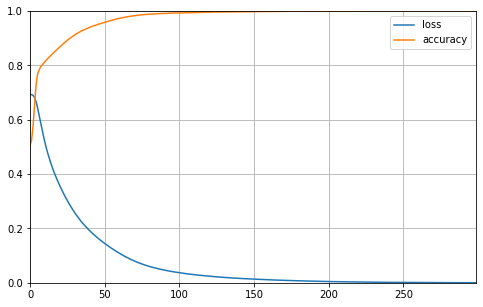

In [88]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [89]:
model.evaluate(X_test, y_test)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.00031819927773904055, 1.0]

In [90]:
# given an example:
X_new = X_test[1,:]
y_proba = model.predict(X_new)

In [94]:
y_proba

array([[9.9996400e-01, 9.9990028e-01, 2.5033951e-06, 2.3543835e-06,
        9.9999213e-01, 1.3005733e-04, 1.5944242e-05, 1.4901161e-06,
        9.9998796e-01, 6.3180923e-06, 9.9999654e-01, 1.4603138e-05,
        1.3440847e-05, 9.9998337e-01, 9.9979818e-01, 9.9998802e-01,
        4.5449589e-05, 9.9999464e-01, 7.2710878e-05, 9.9967408e-01]],
      dtype=float32)

In [95]:
np.around(y_proba, decimals=1)

array([[1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
        0., 1., 0., 1.]], dtype=float32)

In [92]:
y_test[1,:]

matrix([[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]])

Use several supervised learning method and then compare the best one with the score return.
Will try about the decesion trees, random forest, linear regression, SVM, and logistic regression. No need to use neural network (unless we need to deal with imaginary part).

Facing complex number later when dealing with images can maybe use this one:
[Deep complex networks](https://github.com/ChihebTrabelsi/deep_complex_networks)<br>
**This github page also contains the associated with paper**